# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [3]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [4]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Bayesian regression

This notebook presents a simple example of Bayesian regression using synthetic data

## More snow?

I am under the impression that we don't get as much snow around here as we used to.  By "around here" I mean Norfolk County, Massachusetts, where I was born, grew up, and currently reside.  And by "used to" I mean compared to when I was young, like in 1978 when we got [27 inches of snow](https://en.wikipedia.org/wiki/Northeastern_United_States_blizzard_of_1978) and I didn't have to go to school for a couple of weeks.

Fortunately, we can test my conjecture with data.  Norfolk County happens to be the location of the [Blue Hill Meteorological Observatory](https://en.wikipedia.org/wiki/Blue_Hill_Meteorological_Observatory), which keeps the oldest continuous weather record in North America.

Data from this and many other weather stations is available from the [National Oceanic and Atmospheric Administration](https://www.ncdc.noaa.gov/cdo-web/search) (NOAA).  I collected data from the Blue Hill Observatory from May 11, 1967 to May 11, 2020.  The following cell downloads the data as a CSV file.

In [88]:
import os

datafile = '2239075.csv'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2239075.csv

--2020-08-14 14:53:07--  https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2239075.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/2239075.csv [following]
--2020-08-14 14:53:08--  https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/2239075.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.116.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.116.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1853619 (1.8M) [text/plain]
Saving to: ‘2239075.csv’

2239075.csv         100%[===================>]   1.77M  2.05MB/s    in 0.9s    

2020-08-14 14:53:09 (2.05 MB/s) - ‘2239075.csv’ saved [1853619/1853619]



We can read the data into a Pandas `DataFrame`:

In [62]:
df = pd.read_csv('2239075.csv', parse_dates=[2])

Here's what the last few rows look like.

In [82]:
df.tail()

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,...,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18,year
19355,USC00190736,"BLUE HILL COOP, MA US",2020-05-07,0.00,0.0,0.0,57,37.0,43.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
19356,USC00190736,"BLUE HILL COOP, MA US",2020-05-08,0.00,0.0,0.0,63,42.0,45.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
19357,USC00190736,"BLUE HILL COOP, MA US",2020-05-09,0.45,0.0,0.0,57,34.0,34.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
19358,USC00190736,"BLUE HILL COOP, MA US",2020-05-10,0.00,0.0,0.0,44,31.0,38.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
19359,USC00190736,"BLUE HILL COOP, MA US",2020-05-11,0.00,0.0,0.0,59,38.0,50.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020


I'll add a column that contains just the year part of the dates.

In [102]:
df['YEAR'] = df['DATE'].dt.year

And use `groupby` to add up the total snowfall in each year.

In [172]:
snow = df.groupby('YEAR')['SNOW'].sum()
len(snow)

54

The first and last years are not complete, so I'll drop them.

In [173]:
complete = snow.iloc[1:-1]
len(complete)

52

The following figure shows total snowfall during each of the complete years in my lifetime.

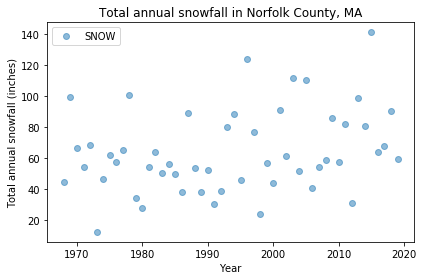

In [174]:
complete.plot(style='o', alpha=0.5)

decorate(xlabel='Year',
         ylabel='Total annual snowfall (inches)',
         title='Total annual snowfall in Norfolk County, MA')

Looking at this plot, it's hard to say whether snowfall is increasing, decreasing, or unchanged.  In the last decade, we've had several years with more snow than 1978, including 2015, which was the snowiest winter in the Boston area in modern history, with a total of 141 inches.

In [175]:
complete.loc[[1978, 1996, 2015]]

YEAR
1978    100.6
1996    124.2
2015    141.1
Name: SNOW, dtype: float64

This kind of question -- looking at noisy data and wondering whether it is going up or down -- is precisely the question we can answer with Bayesian regression.

The foundation of regression (Bayesian or not) is the model that a time series like this is the sum of two parts:

1. A linear function of time, and

2. A series of random values drawn from a distribution that is not changing over time.

Mathematically,

$y = a x + b + \epsilon$

where $y$ is the series of measurements (snowfall in this example), $x$ is the series of times (years) and $\epsilon$ is the series of random values.

$a$ and $b$ are the slope and intercept of the line through the data.  They are unknown parameters, so we will use the data to estimate them.

We don't know the distribution of $\epsilon$, so we'll make the additional assumption that it is a normal distribution with mean 0 and unknown standard deviation, $\sigma$.  To see whether this assumption is reasonable, I'll plot the distribution of total snowfall and a normal model with the same mean and standard deviations.  

In [176]:
pmf_snowfall = Pmf.from_seq(complete)

mean, std = pmf_snowfall.mean(), pmf_snowfall.std()
mean, std

(64.19038461538462, 26.288021984395684)

In [177]:
from scipy.stats import norm

dist = norm(mean, std)
qs = pmf_snowfall.qs
ps = dist.cdf(qs)

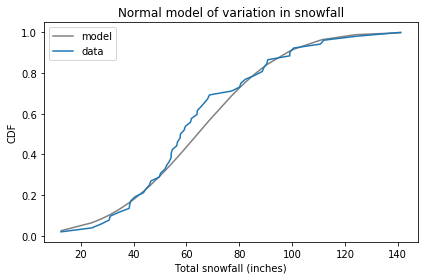

In [178]:
plt.plot(qs, ps, color='gray', label='model')
pmf_snowfall.make_cdf().plot(label='data')

decorate(xlabel='Total snowfall (inches)',
         ylabel='CDF',
         title='Normal model of variation in snowfall')

We've had more winters below the mean than expected, but overall this looks like a reasonable model, particularly in the tails, which are often problematic.

This model has three parameters: slope, intercept, and standard deviation of $\epsilon$.  In the next section we'll see how to compute the likelihood of the data, given these parameters; then we'll see how to estimate them.


In [203]:
data = complete.reset_index()
data.head()

,YEAR,SNOW
0,1968,44.7
1,1969,99.2
2,1970,66.8
3,1971,54.6
4,1972,68.7


In [180]:
offset = data['YEAR'].mean()
offset

1993.5

In [204]:
data['x'] = data['YEAR'] - offset
data['x'].mean()

0.0

In [182]:
import statsmodels.formula.api as smf

formula = 'SNOW ~ x'
results = smf.ols(formula, data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SNOW   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     4.669
Date:                Fri, 14 Aug 2020   Prob (F-statistic):             0.0355
Time:                        16:14:01   Log-Likelihood:                -241.46
No. Observations:                  52   AIC:                             486.9
Df Residuals:                      50   BIC:                             490.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.1904      3.555     18.054      0.000      57.049      71.332
x              0.5119      0.237      2.161      0.036       0.036       0.988
==============================================================================
Omnibus:                        3.736   Durbin-Watson:                   2.290
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.257
Skew:                           0.613   Prob(JB):                        0.196
Kurtosis:                       2.978   Cond. No.                         15.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Suppose there is a linear relationship between `x` and `y` with slope 2 and intercept 1, but the measurements of `y` are noisy; specifically, the noise is Gaussian with mean 0 and `sigma = 0.3`. 

In [183]:
inter = 64
slope = 0.51
sigma = 26

In [184]:
xs = data['x']
ys = data['SNOW']

In [185]:
resid = slope * xs + inter - ys
resid.describe()

count    52.000000
mean     -0.190385
std      25.385697
min     -66.135000
25%     -14.125000
50%       6.565000
75%      17.442500
max      42.335000
dtype: float64

In [186]:
densities = norm(0, sigma).pdf(resid)
densities

array([0.01490073, 0.00285242, 0.01305324, 0.01529515, 0.01279708,
       0.0044134 , 0.01470964, 0.01474532, 0.01526593, 0.01426784,
       0.00354561, 0.010655  , 0.00809097, 0.01521138, 0.01494539,
       0.01455552, 0.01525171, 0.01425735, 0.01077026, 0.00837361,
       0.01468642, 0.01030307, 0.01430933, 0.00718604, 0.00993735,
       0.01258966, 0.0098625 , 0.01182567, 0.00117652, 0.0139576 ,
       0.00411173, 0.01420639, 0.01015782, 0.01038433, 0.01482279,
       0.00386994, 0.01221638, 0.00446989, 0.00796445, 0.01248853,
       0.01372076, 0.01330202, 0.01304467, 0.01437819, 0.00407589,
       0.00960892, 0.01492131, 0.00060389, 0.01392   , 0.01463711,
       0.01329929, 0.01226386])

In [187]:
likelihood = densities.prod()
likelihood

1.290411849292259e-105

## Estimation

We can solve the problem first using a grid algorithm, with uniform priors for slope, intercept, and sigma.

As an exercise, fill in this likelihood function, then test it using the code below.

Your results will depend on the random data you generated, but in general you should find that the posterior marginal distributions peak near the actual parameters.

In [401]:
slopes = np.linspace(-0.5, 1.5, 51)
prior_slope = Pmf(1, slopes)
prior_slope.index.name = 'Slope'

In [402]:
inters = np.linspace(55, 75, 41)
prior_inter = Pmf(1, inters)
prior_inter.index.name = 'Intercept'

In [403]:
sigmas = np.linspace(20, 35, 31)
prior_sigma = Pmf(1, sigmas)
prior_sigma.index.name = 'Sigma'

In [404]:
from utils import make_joint

joint2 = make_joint(prior_inter, prior_slope)
joint2.head()

Intercept,55.0,55.5,56.0,56.5,57.0,57.5,58.0,58.5,59.0,59.5,...,70.5,71.0,71.5,72.0,72.5,73.0,73.5,74.0,74.5,75.0
Slope,,,,,,,,,,,,,,,,,,,,,
-0.50,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-0.46,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-0.42,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-0.38,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-0.34,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [405]:
prior2 = Pmf(joint2.stack())
prior2.head()

Slope  Intercept
-0.5   55.0         1
       55.5         1
       56.0         1
       56.5         1
       57.0         1
dtype: int64

In [406]:
joint3 = make_joint(prior_sigma, prior2)
joint3.head()

Sigma            20.0  20.5  21.0  21.5  22.0  22.5  23.0  23.5  24.0  24.5  \
Slope Intercept                                                               
-0.5  55.0          1     1     1     1     1     1     1     1     1     1   
      55.5          1     1     1     1     1     1     1     1     1     1   
      56.0          1     1     1     1     1     1     1     1     1     1   
      56.5          1     1     1     1     1     1     1     1     1     1   
      57.0          1     1     1     1     1     1     1     1     1     1   

Sigma            ...  30.5  31.0  31.5  32.0  32.5  33.0  33.5  34.0  34.5  \
Slope Intercept  ...                                                         
-0.5  55.0       ...     1     1     1     1     1     1     1     1     1   
      55.5       ...     1     1     1     1     1     1     1     1     1   
      56.0       ...     1     1     1     1     1     1     1     1     1   
      56.5       ...     1     1     1     1     1     1     1     1     1   
      57.0       ...     1     1     1     1     1     1     1     1     1   

Sigma            35.0  
Slope Intercept        
-0.5  55.0          1  
      55.5          1  
      56.0          1  
      56.5          1  
      57.0          1  

[5 rows x 31 columns]

In [407]:
prior3 = Pmf(joint3.stack())
prior3.head()

Slope  Intercept  Sigma
-0.5   55.0       20.0     1
                  20.5     1
                  21.0     1
                  21.5     1
                  22.0     1
dtype: int64

In [408]:
len(prior3)

64821

In [409]:
xs = data['x']
ys = data['SNOW']

In [410]:
likelihood = prior3.copy()

for slope, inter, sigma in prior3.index:
    resid = slope * xs + inter - ys
    densities = norm.pdf(resid, 0, sigma)
    likelihood.loc[slope, inter, sigma] = densities.prod()

In [411]:
likelihood.head()

Slope  Intercept  Sigma
-0.5   55.0       20.0     7.192950e-116
                  20.5     3.868990e-115
                  21.0     1.741017e-114
                  21.5     6.671900e-114
                  22.0     2.211914e-113
dtype: float64

In [412]:
likelihood.sum()

4.593476917509183e-102

In [413]:
posterior3 = prior3 * likelihood
posterior3.normalize()
posterior3.shape

(64821,)

In [414]:
posterior3_unstacked = posterior3.unstack()
posterior3_unstacked.head()

Sigma                    20.0          20.5          21.0          21.5  \
Slope Intercept                                                           
-0.5  55.0       1.565905e-14  8.422792e-14  3.790194e-13  1.452473e-12   
      55.5       2.799915e-14  1.464449e-13  6.420620e-13  2.401597e-12   
      56.0       4.846293e-14  2.468643e-13  1.056064e-12  3.860810e-12   
      56.5       8.120073e-14  4.034667e-13  1.686557e-12  6.034523e-12   
      57.0       1.317030e-13  6.393264e-13  2.615228e-12  9.170513e-12   

Sigma                    22.0          22.5          23.0          23.5  \
Slope Intercept                                                           
-0.5  55.0       4.815338e-12  1.400469e-11  3.617675e-11  8.392474e-11   
      55.5       7.784035e-12  2.216584e-11  5.613900e-11  1.278471e-10   
      56.0       1.224948e-11  3.419344e-11  8.500160e-11  1.902253e-10   
      56.5       1.876575e-11  5.141019e-11  1.255790e-10  2.764537e-10   
      57.0       2.798654e-11  7.533613e-11  1.810231e-10  3.924220e-10   

Sigma                    24.0          24.5  ...          30.5          31.0  \
Slope Intercept                              ...                               
-0.5  55.0       1.765777e-10  3.399368e-10  ...  8.034474e-09  8.046543e-09   
      55.5       2.643621e-10  5.007040e-10  ...  1.031522e-08  1.024845e-08   
      56.0       3.869554e-10  7.217023e-10  ...  1.305962e-08  1.287750e-08   
      56.5       5.537590e-10  1.017957e-09  ...  1.630472e-08  1.596359e-08   
      57.0       7.747809e-10  1.405060e-09  ...  2.007368e-08  1.952335e-08   

Sigma                    31.5          32.0          32.5          33.0  \
Slope Intercept                                                           
-0.5  55.0       7.847997e-09  7.469618e-09  6.950995e-09  6.335147e-09   
      55.5       9.919712e-09  9.373118e-09  8.662088e-09  7.842563e-09   
      56.0       1.237512e-08  1.161332e-08  1.066235e-08  9.593453e-09   
      56.5       1.523736e-08  1.420741e-08  1.296398e-08  1.159598e-08   
      57.0       1.851741e-08  1.716169e-08  1.556964e-08  1.385018e-08   

Sigma                    33.5          34.0          34.5          35.0  
Slope Intercept                                                          
-0.5  55.0       5.663946e-09  4.974744e-09  4.298312e-09  3.657981e-09  
      55.5       6.967450e-09  6.082740e-09  5.225327e-09  4.422329e-09  
      56.0       8.472232e-09  7.354341e-09  6.283269e-09  5.289952e-09  
      56.5       1.018336e-08  8.792339e-09  7.473335e-09  6.261000e-09  
      57.0       1.209911e-08  1.039396e-08  8.792247e-09  7.332073e-09  

[5 rows x 31 columns]

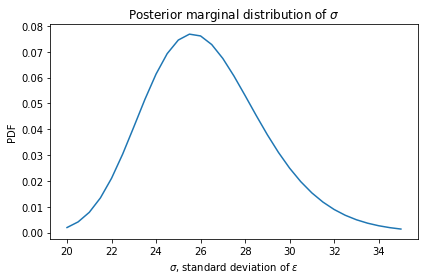

In [415]:
from utils import marginal

posterior_sigma = marginal(posterior3_unstacked, 0)
posterior_sigma.plot()

decorate(xlabel='$\sigma$, standard deviation of $\epsilon$',
         ylabel='PDF',
         title='Posterior marginal distribution of $\sigma$')

In [416]:
posterior2 = marginal(posterior3_unstacked, 1)
posterior2.head()

Slope  Intercept
-0.5   55.0         1.088531e-07
       55.5         1.400255e-07
       56.0         1.778945e-07
       56.5         2.231539e-07
       57.0         2.763324e-07
dtype: float64

In [417]:
joint_posterior = posterior2.unstack().transpose()
joint_posterior.head()

Slope,-0.50,-0.46,-0.42,-0.38,-0.34,-0.30,-0.26,-0.22,-0.18,-0.14,...,1.14,1.18,1.22,1.26,1.30,1.34,1.38,1.42,1.46,1.50
Intercept,,,,,,,,,,,,,,,,,,,,,
55.0,1.088531e-07,1.804076e-07,2.949886e-07,4.756651e-07,7.560171e-07,0.000001,0.000002,0.000003,0.000004,0.000006,...,0.000008,0.000005,0.000004,0.000002,0.000002,9.885575e-07,6.274826e-07,3.924648e-07,2.420038e-07,1.471870e-07
55.5,1.400255e-07,2.329079e-07,3.822384e-07,6.186706e-07,9.870532e-07,0.000002,0.000002,0.000004,0.000005,0.000008,...,0.000010,0.000007,0.000005,0.000003,0.000002,1.293595e-06,8.179717e-07,5.096762e-07,3.131106e-07,1.897402e-07
56.0,1.778945e-07,2.969361e-07,4.890710e-07,7.944823e-07,1.272252e-06,0.000002,0.000003,0.000005,0.000007,0.000011,...,0.000013,0.000009,0.000006,0.000004,0.000003,1.671061e-06,1.052728e-06,6.535394e-07,4.000356e-07,2.415544e-07
56.5,2.231539e-07,3.737507e-07,6.177343e-07,1.007052e-06,1.618446e-06,0.000003,0.000004,0.000006,0.000009,0.000014,...,0.000017,0.000012,0.000008,0.000005,0.000003,2.130337e-06,1.337233e-06,8.272033e-07,5.045584e-07,3.036196e-07
57.0,2.763324e-07,4.643366e-07,7.700312e-07,1.259621e-06,2.031355e-06,0.000003,0.000005,0.000008,0.000012,0.000017,...,0.000022,0.000015,0.000010,0.000007,0.000004,2.679369e-06,1.676039e-06,1.033228e-06,6.280924e-07,3.767026e-07


In [418]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

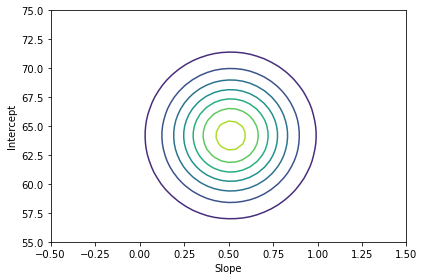

In [419]:
plot_contour(joint_posterior)

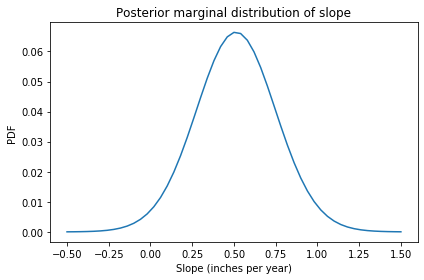

In [420]:
posterior_slope = marginal(joint_posterior, 0)

posterior_slope.plot()
decorate(xlabel='Slope (inches per year)',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [387]:
posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(0.5118684538574172, array([0.1, 0.9]))

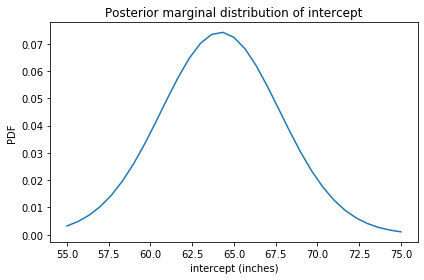

In [388]:
posterior_inter = marginal(joint_posterior, 1)

posterior_inter.plot()
decorate(xlabel='intercept (inches)',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [389]:
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(64.22861083706859, array([58.33333333, 70.33333333]))

So it looks like my conjecture was wrong, we are actually getting more snow around here than we used to, increasing at a rate of about a half-inch per year, which is substantial.  On average, we get an additional 25 inches of snow per year than we did when I was young.

This example shows that with slow-moving trends and noisy data, your instincts can be misleading.  In this case, you might suspect that I underestimate the amount of snow when I was young because I wanted snow, and overestimate it now because I don't.  But you would be mistaken.

During the Blizzard of 1978, we did not have a snowblower and my brother and I had to shovel.  My sister got a pass for no good reason.  Our driveway was about 60 feet long and three cars wide near the garage.  And we had to shovel Mr. Crocker's driveway, too, for which we were not allowed to accept payment.  However, as I recall, it was during this excavation that I accidentally hit my brother with a shovel on the head, and it bled a lot because, you know, scalp wounds.

Anyway, the point is that I don't think I underestimate the amount of snow when I was young because I have fond memories of it. 

## Optimization

In [421]:
sigmas = joint3.columns
likelihood = joint3.copy()

for slope, inter in joint3.index:
    resid = slope * xs + inter - ys
    resid_mesh, sigma_mesh = np.meshgrid(resid, sigmas)
    densities = norm.pdf(resid_mesh, 0, sigma_mesh)
    likelihood.loc[slope, inter] = densities.prod(axis=1)

In [422]:
from utils import normalize

posterior3_unstacked = joint3 * likelihood
normalize(posterior3_unstacked)

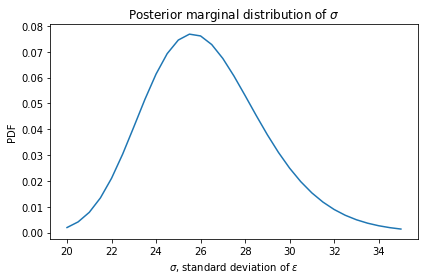

In [423]:
posterior_sigma = marginal(posterior3_unstacked, 0)
posterior_sigma.plot()

decorate(xlabel='$\sigma$, standard deviation of $\epsilon$',
         ylabel='PDF',
         title='Posterior marginal distribution of $\sigma$')

In [424]:
posterior2 = marginal(posterior3_unstacked, 1)
posterior2.head()

Slope  Intercept
-0.5   55.0         1.088531e-07
       55.5         1.400255e-07
       56.0         1.778945e-07
       56.5         2.231539e-07
       57.0         2.763324e-07
dtype: float64

In [425]:
joint_posterior = posterior2.unstack().transpose()
joint_posterior.head()

Slope,-0.50,-0.46,-0.42,-0.38,-0.34,-0.30,-0.26,-0.22,-0.18,-0.14,...,1.14,1.18,1.22,1.26,1.30,1.34,1.38,1.42,1.46,1.50
Intercept,,,,,,,,,,,,,,,,,,,,,
55.0,1.088531e-07,1.804076e-07,2.949886e-07,4.756651e-07,7.560171e-07,0.000001,0.000002,0.000003,0.000004,0.000006,...,0.000008,0.000005,0.000004,0.000002,0.000002,9.885575e-07,6.274826e-07,3.924648e-07,2.420038e-07,1.471870e-07
55.5,1.400255e-07,2.329079e-07,3.822384e-07,6.186706e-07,9.870532e-07,0.000002,0.000002,0.000004,0.000005,0.000008,...,0.000010,0.000007,0.000005,0.000003,0.000002,1.293595e-06,8.179717e-07,5.096762e-07,3.131106e-07,1.897402e-07
56.0,1.778945e-07,2.969361e-07,4.890710e-07,7.944823e-07,1.272252e-06,0.000002,0.000003,0.000005,0.000007,0.000011,...,0.000013,0.000009,0.000006,0.000004,0.000003,1.671061e-06,1.052728e-06,6.535394e-07,4.000356e-07,2.415544e-07
56.5,2.231539e-07,3.737507e-07,6.177343e-07,1.007052e-06,1.618446e-06,0.000003,0.000004,0.000006,0.000009,0.000014,...,0.000017,0.000012,0.000008,0.000005,0.000003,2.130337e-06,1.337233e-06,8.272033e-07,5.045584e-07,3.036196e-07
57.0,2.763324e-07,4.643366e-07,7.700312e-07,1.259621e-06,2.031355e-06,0.000003,0.000005,0.000008,0.000012,0.000017,...,0.000022,0.000015,0.000010,0.000007,0.000004,2.679369e-06,1.676039e-06,1.033228e-06,6.280924e-07,3.767026e-07


In [426]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

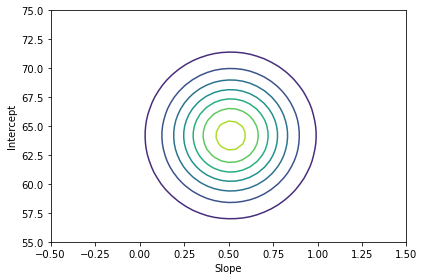

In [427]:
plot_contour(joint_posterior)

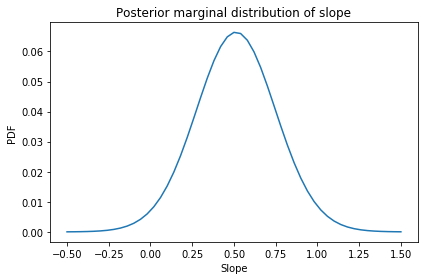

In [428]:
posterior_slope = marginal(joint_posterior, 0)

posterior_slope.plot()
decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [429]:
posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(0.5118660811960725, array([0.1, 0.9]))

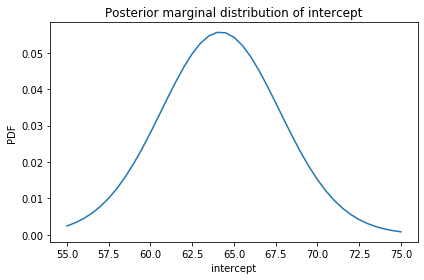

In [430]:
posterior_inter = marginal(joint_posterior, 1)

posterior_inter.plot()
decorate(xlabel='intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [431]:
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(64.23067760617815, array([58.5, 70. ]))

## Empirical Bayes

## Marathon world record

For many running events, if you plot the world record pace over time, the result is a remarkably straight line.  Many people have speculated about possible reasons for this phenomenon, [including me](http://allendowney.blogspot.com/2011/04/two-hour-marathon-in-2045.html).

As another example of Bayesian regression, we'll consider the world record progression for the Marathon (for male runners), estimate the parameters of a linear model, and use the model to predict when a runner will break the two-hour barrier.  (Note: In 2019 Eliud Kipchoge ran the marathon distance in under two hours, which is an astonishing achievement that I fully appreciate, but for several reasons it did not count as a Marathon world record; the predictions we generate will be for a Marathon run under conditions that qualify for a world record.)

The following cell downloads a web page from Wikipedia that includes a table of Marathon world records and uses Pandas to put the data in a `DataFrame`.

In [438]:
url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
tables = pd.read_html(url)
len(tables)

5

If that doesn't work, I have made a copy of this page available.  The following cell downloads and parses it.

In [439]:
#import os

#datafile = 'Marathon_world_record_progression.html'
#if not os.path.exists(datafile):
#    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/data/Marathon_world_record_progression.html

#tables = pd.read_html(datafile)
#len(tables)

Either way, it's the first table we want.

In [440]:
table = tables[0]
table.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes
0,2:55:18.4,Johnny Hayes,United States,"July 24, 1908","London, United Kingdom",IAAF[53],Time was officially recorded as 2:55:18 2/5.[5...
1,2:52:45.4,Robert Fowler,United States,"January 1, 1909","Yonkers,[nb 5] United States",IAAF[53],Note.[56]
2,2:46:52.8,James Clark,United States,"February 12, 1909","New York City, United States",IAAF[53],Note.[56]
3,2:46:04.6,Albert Raines,United States,"May 8, 1909","New York City, United States",IAAF[53],Note.[56]
4,2:42:31.0,Henry Barrett,United Kingdom,"May 26, 1909[nb 6]","Polytechnic Marathon, London, United Kingdom",IAAF[53],Note.[56]


We can use Pandas to parse the dates.  A couple of them include notes that could cause errors, but the argment `errors='coerce'` tells Pandas to fill invalid dates with `NaT`, which is a version of `NaN` that represents "not a time". 

In [441]:
table['date'] = pd.to_datetime(table['Date'], errors='coerce')
table['date'].head()

0   1908-07-24
1   1909-01-01
2   1909-02-12
3   1909-05-08
4          NaT
Name: date, dtype: datetime64[ns]

We can also use Pandas to parse the record times.

In [451]:
table['time'] = pd.to_timedelta(table['Time'])

And convert the times to paces in miles per hour.

In [452]:
table['mph'] = 26.2 / table['time'].dt.total_seconds() * 3600
table['mph'].head()

0    8.967143
1    9.099504
2    9.419942
3    9.465508
4    9.672854
Name: mph, dtype: float64

The following function plots the results.

In [453]:
def plot_speeds(df):
    """Plot marathon world record speed as a function of time.
    
    df: DataFrame with date and mph
    """
    plt.axhline(13.1, color='gray')
    plt.plot(df['date'], df['mph'], 'o', alpha=0.5)
    
    decorate(xlabel='Date',
             ylabel='Speed (mph)')

And here's what it looks like.

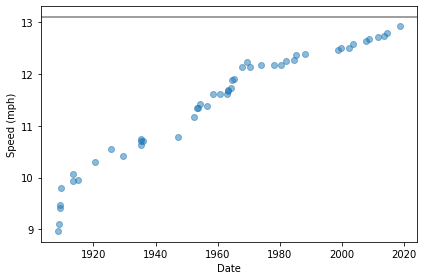

In [454]:
plot_speeds(table)

It's not a perfectly straight line.  In the early years of the marathon, the record pace increased quickly.  Since about 1970, it has been increasing more slowly.

For our analysis, let's focus on the recent progression, starting in 1970.

In [455]:
recent = table['date'] > pd.to_datetime('1970')

Here's what that looks like.

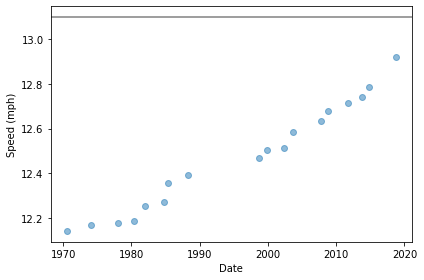

In [456]:
data = table.loc[recent].copy()
plot_speeds(data)

That seems like a straighter line, although it's possible that the slope is increasing.

To prepare the data for regression, I'll substract away the approximate midpoint of the time interval, 1995.

In [457]:
offset = pd.to_datetime('1995')
timedelta = table['date'] - offset

And convert the time differences to floating-point numbers in years.

In [458]:
data['x'] = timedelta.dt.total_seconds() / 3600 / 24 / 365.24
data['x'].describe()

count    18.000000
mean      0.740913
std      15.417918
min     -24.444201
25%     -12.352152
50%       4.264319
75%      13.492498
max      23.707699
Name: x, dtype: float64

As in the previous example, I'll use ordinary least squares to generate point estimates for the parameters, which will help with choosing priors.

In [459]:
import statsmodels.formula.api as smf

formula = 'mph ~ x'
results = smf.ols(formula, data=data).fit()
results.summary()

/home/downey/anaconda3/envs/ThinkBayes2/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mph   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     530.7
Date:                Fri, 14 Aug 2020   Prob (F-statistic):           1.07e-13
Time:                        19:53:24   Log-Likelihood:                 32.294
No. Observations:                  18   AIC:                            -60.59
Df Residuals:                      16   BIC:                            -58.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.4605      0.010   1237.317      0.000      12.439      12.482
x              0.0155      0.001     23.037      0.000       0.014       0.017
==============================================================================
Omnibus:                        1.748   Durbin-Watson:                   1.101
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.174
Skew:                           0.612   Prob(JB):                        0.556
Kurtosis:                       2.745   Cond. No.                         15.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If you get a warning about a kurtosis test, you can ignore it.  The estimated intercept is about 12.5 mph, which is the expected world record pace in 1995.  The estimated slope is about 0.016 mph per year, which is rate we estimate the world record pace is increasing.

These parameters give us a good idea where we should put the prior distributions.

## The priors

In [497]:
slopes = np.linspace(0.012, 0.018, 51)
prior_slope = Pmf(1, slopes)
prior_slope.index.name = 'Slope'

In [513]:
inters = np.linspace(12.4, 12.5, 41)
prior_inter = Pmf(1, inters)
prior_inter.index.name = 'Intercept'

In [514]:
sigmas = np.linspace(0.01, 0.21, 31)
prior_sigma = Pmf(1, sigmas)
prior_sigma.index.name = 'Sigma'

In [515]:
def make_joint3(pmf1, pmf2, pmf3):
    """
    """
    joint2 = make_joint(pmf2, pmf1).stack()
    joint3 = make_joint(pmf3, joint2).stack()
    return joint3

In [516]:
joint3 = make_joint3(prior_slope, prior_inter, prior_sigma)
joint3.head()

Slope  Intercept  Sigma   
0.012  12.4       0.010000    1
                  0.016667    1
                  0.023333    1
                  0.030000    1
                  0.036667    1
dtype: int64

In [517]:
prior = joint3.unstack()
prior.head()

Sigma            0.010000  0.016667  0.023333  0.030000  0.036667  0.043333  \
Slope Intercept                                                               
0.012 12.4000           1         1         1         1         1         1   
      12.4025           1         1         1         1         1         1   
      12.4050           1         1         1         1         1         1   
      12.4075           1         1         1         1         1         1   
      12.4100           1         1         1         1         1         1   

Sigma            0.050000  0.056667  0.063333  0.070000  ...  0.150000  \
Slope Intercept                                          ...             
0.012 12.4000           1         1         1         1  ...         1   
      12.4025           1         1         1         1  ...         1   
      12.4050           1         1         1         1  ...         1   
      12.4075           1         1         1         1  ...         1   
      12.4100           1         1         1         1  ...         1   

Sigma            0.156667  0.163333  0.170000  0.176667  0.183333  0.190000  \
Slope Intercept                                                               
0.012 12.4000           1         1         1         1         1         1   
      12.4025           1         1         1         1         1         1   
      12.4050           1         1         1         1         1         1   
      12.4075           1         1         1         1         1         1   
      12.4100           1         1         1         1         1         1   

Sigma            0.196667  0.203333  0.210000  
Slope Intercept                                
0.012 12.4000           1         1         1  
      12.4025           1         1         1  
      12.4050           1         1         1  
      12.4075           1         1         1  
      12.4100           1         1         1  

[5 rows x 31 columns]

In [518]:
from scipy.stats import norm

xs = data['x']
ys = data['mph']
sigmas = prior_sigma.index

likelihood = prior.copy()

for slope, inter in prior.index:
    resid = slope * xs + inter - ys
    sigma_mesh, resid_mesh = np.meshgrid(sigmas, resid)
    densities = norm.pdf(resid_mesh, 0, sigma_mesh)
    like = densities.prod(axis=0)
    likelihood.loc[slope, inter] = like

In [519]:
from utils import normalize

posterior = prior * likelihood
normalize(posterior)
posterior.head()

Sigma                 0.010000       0.016667      0.023333      0.030000  \
Slope Intercept                                                             
0.012 12.4000    1.262529e-312  3.343049e-109  1.094238e-54  3.900183e-33   
      12.4025    1.526143e-300  7.478080e-105  1.812674e-52  8.581608e-32   
      12.4050    5.989187e-289  1.115702e-100  2.442239e-50  1.666348e-30   
      12.4075    7.630609e-278   1.110241e-96  2.676191e-48  2.855458e-29   
      12.4100    3.156234e-267   7.368799e-93  2.385101e-46  4.318164e-28   

Sigma                0.036667      0.043333      0.050000      0.056667  \
Slope Intercept                                                           
0.012 12.4000    8.441749e-23  2.931639e-17  4.406051e-14  3.438933e-12   
      12.4025    6.685285e-22  1.289880e-16  1.340737e-13  8.178824e-12   
      12.4050    4.869301e-21  5.345266e-16  3.900269e-13  1.878203e-11   
      12.4075    3.261915e-20  2.086268e-15  1.084682e-12  4.164655e-11   
      12.4100    2.009730e-19  7.669228e-15  2.883810e-12  8.916616e-11   

Sigma                0.063333      0.070000  ...      0.150000      0.156667  \
Slope Intercept                              ...                               
0.012 12.4000    4.785065e-11  2.307915e-10  ...  3.793045e-11  2.285756e-11   
      12.4025    9.574364e-11  4.071912e-10  ...  4.292273e-11  2.560097e-11   
      12.4050    1.862736e-10  7.021114e-10  ...  4.832982e-11  2.854251e-11   
      12.4075    3.523807e-10  1.183157e-09  ...  5.414665e-11  3.167652e-11   
      12.4100    6.481747e-10  1.948534e-09  ...  6.036102e-11  3.499388e-11   

Sigma                0.163333      0.170000      0.176667      0.183333  \
Slope Intercept                                                           
0.012 12.4000    1.376737e-11  8.308626e-12  5.033437e-12  3.065116e-12   
      12.4025    1.528062e-11  9.148221e-12  5.502706e-12  3.329617e-12   
      12.4050    1.688882e-11  1.003352e-11  5.994081e-12  3.604858e-12   
      12.4075    1.858774e-11  1.096175e-11  6.505842e-12  3.889811e-12   
      12.4100    2.037146e-11  1.192931e-11  7.035889e-12  4.183262e-12   

Sigma                0.190000      0.196667      0.203333      0.210000  
Slope Intercept                                                          
0.012 12.4000    1.878044e-12  1.158644e-12  7.201015e-13  4.510042e-13  
      12.4025    2.028500e-12  1.245055e-12  7.702245e-13  4.803725e-13  
      12.4050    2.184192e-12  1.334024e-12  8.215978e-13  5.103498e-13  
      12.4075    2.344515e-12  1.425200e-12  8.740161e-13  5.408163e-13  
      12.4100    2.508776e-12  1.518185e-12  9.272522e-13  5.716414e-13  

[5 rows x 31 columns]

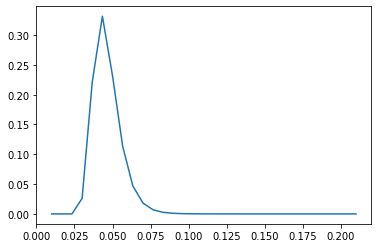

In [520]:
from utils import marginal

posterior_sigma = marginal(posterior, 0)
posterior_sigma.plot()

In [521]:
posterior_pmf = marginal(posterior, 1)
posterior_pmf.shape

(2091,)

In [522]:
posterior_joint = posterior_pmf.unstack().transpose()
posterior_joint.shape

(41, 51)

In [523]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

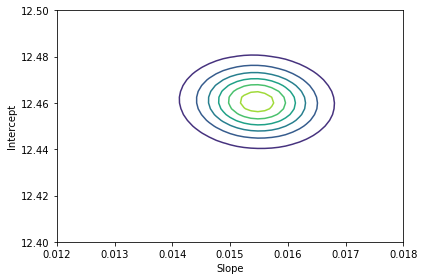

In [524]:
plot_contour(posterior_joint)
decorate(title='')

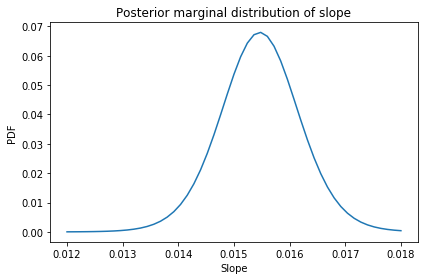

In [525]:
posterior_slope = marginal(posterior_joint, 0)

posterior_slope.plot()
decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [526]:
posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(0.01546191796847868, array([0.01428, 0.01668]))

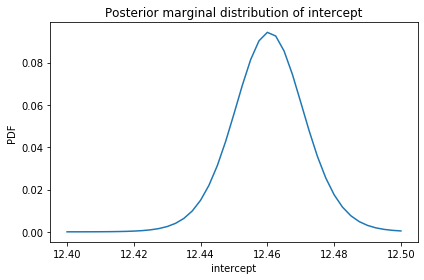

In [527]:
posterior_inter = marginal(posterior_joint, 1)

posterior_inter.plot()
decorate(xlabel='intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [183]:
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(12.460507580847914, array([12.44, 12.48]))

## Prediction

In [184]:
posterior_pmf = Pmf(posterior3.stack())
posterior_pmf.head()

Slope  Intercept  Sigma
0.01   12.4       0.01      0.000000e+00
                  0.02     2.651660e-115
                  0.03      1.140654e-50
                  0.04      3.462615e-29
                  0.05      6.013886e-20
dtype: float64

In [185]:
sample = posterior_pmf.sample(101)
xs = np.arange(-25, 50, 2)
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter, sigma) in enumerate(sample):
    pred[i] = inter + slope * xs + norm(0, sigma).rvs(len(xs))
    
pred.shape

(101, 38)

In [187]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
median.shape

(38,)

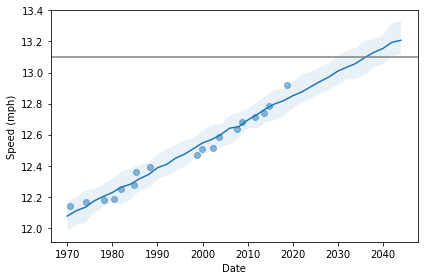

In [190]:
times = pd.to_timedelta(xs*365.24, unit='days') + offset

plt.fill_between(times, low, high, alpha=0.1)
plt.plot(times, median, color='C0')

plot_speeds(data)

In [189]:
from scipy.interpolate import interp1d

future = np.array([interp1d(high, xs)(13.1),
                   interp1d(median, xs)(13.1),
                   interp1d(low, xs)(13.1)])

pd.to_timedelta(future*365.24, unit='day') + offset

DatetimeIndex([   '2029-08-10 15:41:20.272704',
               '2036-03-17 10:24:35.436758400',
               '2041-10-08 03:04:39.181468800'],
              dtype='datetime64[ns]', freq=None)

## Exercises


**Exercise:** Is temperature increasing?

In [83]:
temp = df.groupby('year')['TMAX'].mean()
len(temp)

54

In [84]:
complete_temp = temp.iloc[1:-1]
len(complete_temp)

52

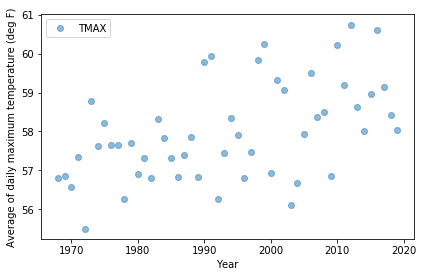

In [86]:
complete_temp.plot(style='o', alpha=0.5)

decorate(xlabel='Year',
         ylabel='Average of daily maximum temperature (deg F)')

## GSS data

Another example using data from the [General Social Survey](https://gss.norc.org/) ...


In [37]:
# Load the data file

# TODO: Update this to point to the ThinkBayes2 repo

import os

datafile = 'gss_eda.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.hdf5

In [38]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 169)

In [40]:
gss.groupby('year')['realrinc'].max()

year
1972              NaN
1973              NaN
1974     96450.000000
1975     75863.000000
1976     81652.000000
1977    201640.000000
1978    135131.000000
1980    139297.000000
1982     97992.000000
1983     81266.000000
1984     87058.000000
1985     96036.000000
1986    101376.000000
1987     92594.000000
1988     83666.000000
1989     80690.000000
1990    103206.000000
1991    111284.000000
1993    123611.000000
1994     97684.000000
1996     87419.000000
1998    150054.000000
2000    134018.000000
2002    234366.656250
2004    134008.437500
2006    159292.265625
2008    480144.468750
2010    109525.156250
2012    341672.375000
2014    132148.078125
2016    164382.031250
2018    151050.718750
Name: realrinc, dtype: float32

In [41]:
gss['rincome'].value_counts()

12.0    14957
9.0      4876
11.0     3838
10.0     3838
2.0      1865
8.0      1745
1.0      1306
3.0      1243
5.0      1091
4.0      1055
6.0       993
7.0       981
Name: rincome, dtype: int64

In [42]:
valid = gss.dropna(subset=['rincome', 'realinc'])
valid.shape

(36916, 169)

2000


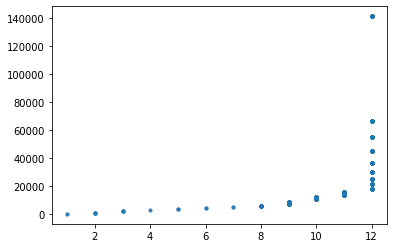

In [50]:
for name, group in valid.groupby('year'):
    if name == 2000:
        print(name)
        plt.plot(group['income'], group['realinc'], '.', alpha=0.3)

In [ ]:
valid = gss.dropna(subset=['realinc', 'polviews'])
valid.shape

In [ ]:
plt.plot(valid['realinc'], valid['polviews'], ',', alpha=0.3)